# 02 Magma plots
Plotting magma substructures overlaid on spectra

In [1]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg
import io

In [2]:
from mist.utils import plot_utils

In [3]:
plot_utils.set_style()

def export_mol(mol, name, width=100, height=100):
    """Save substance structure as PDF"""
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height, )
    opts = drawer.drawOptions()        
    opts.bondLineWidth = 1
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    cairosvg.svg2pdf(bytestring=drawer.GetDrawingText().encode(), write_to=str(name))

In [4]:
input_dir = "../data/paired_spectra/canopus_train/"
input_dir = Path(input_dir)
magma_dir = input_dir / "magma_outputs"
labels_file = input_dir / "labels.tsv"
k = 6
date = datetime.now().strftime("%Y_%m_%d")
res_dir = f"../results/{date}_output_magma_imgs"
res_dir_orig = Path(res_dir)
res_dir_orig.mkdir(exist_ok=True)

In [5]:
name_to_full_smi = dict(pd.read_csv(labels_file, sep="\t")[['spec', 'smiles']].values)
magma_files = list(magma_dir.glob("*.magma"))

In [6]:
# Choose a spectrum
ind = np.random.choice(len(magma_files))
temp_file = magma_files[ind]

# Load in data
spec_name = temp_file.stem
res_dir = res_dir_orig / spec_name
spec_smiles = name_to_full_smi.get(spec_name)

# Process magma file
magma_input = pd.read_csv(temp_file, sep="\t", index_col=0)
mzs, intens = zip(*magma_input[['mz', "intensity"]].values)
magma_input.keys()
smiles = [np.random.choice(eval(j)) if j != "NAN" and not isinstance(j, float) else None for j in magma_input['smiles'].values]
mzs = np.array(mzs)
intens = np.array(intens) / np.max(intens)
top_intens = np.sort(intens)[::-1][:k]

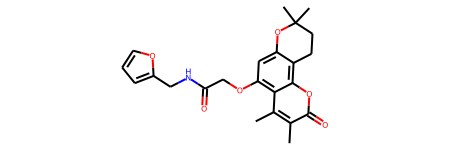

In [7]:
mol = Chem.MolFromSmiles(spec_smiles)
mol

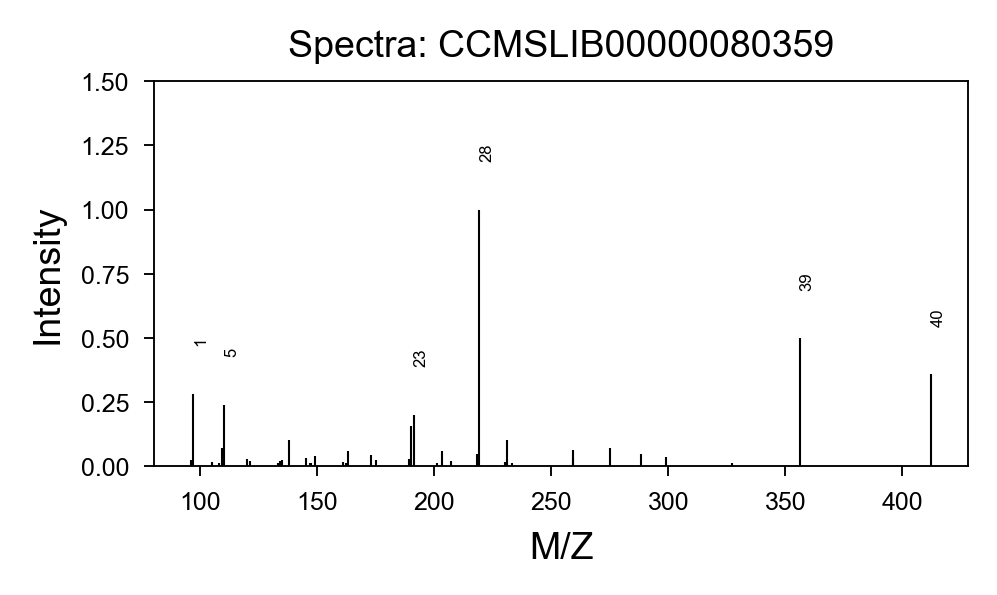

In [8]:
# Create plot
res_dir.mkdir(exist_ok=True)
fig = plt.figure(figsize=(3.5,1.7), dpi=300)
ax = fig.gca()
full_out_smi = res_dir / f"{spec_name}_mol_full.pdf"

mol = Chem.MolFromSmiles(spec_smiles)
Chem.Kekulize(mol)
export_mol(mol, full_out_smi)
for ind, (smi, (m, i)) in enumerate(zip(smiles, zip(mzs, intens))): 
    ax.vlines(x=m, ymin=0,ymax=i, color="black", linewidth=0.5)
    if smi is not None and i in top_intens: 
        mol = Chem.MolFromSmiles(smi, sanitize=False)
        if mol is not None:
            try:
                Chem.Kekulize(mol)
            except:
                continue
            ax.text(x=m, y=i + 0.2, s = f"{ind}", fontsize=4, rotation=90) 
            temp_out_smi = res_dir / f"{spec_name}_mol_{ind}.pdf"
            export_mol(mol, temp_out_smi)

ax.set_xlabel("M/Z")
ax.set_ylabel("Intensity")
ax.set_ylim([0,1.5])
ax.set_title(f"Spectra: {spec_name}")
plt.savefig(res_dir / f"{spec_name}_out_spec.pdf", bbox_inches="tight")